In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
cd/content/gdrive/My Drive/deeplearningbro/pytorch

/content/gdrive/My Drive/deeplearningbro/pytorch


In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
    )

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False)

100%|██████████| 170498071/170498071 [00:01<00:00, 96130137.04it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

cpu is available


In [7]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5) # 합성곱 연산 (입력 채널 수: 3, 출력 채널 수: 6, 필터 크기: 5x5, stride=1(default))
    self.pool1 = nn.MaxPool2d(2,2) # 합성곱 연산 (필터크기 2x2, stride=2)
    self.conv2 = nn.Conv2d(6, 16, 5) # 합성곱 연산 (입력 채널 수: 6, 출력 채널수: 16, 필터 크기: 5x5, stride=1(default))
    self.pool2 = nn.MaxPool2d(2, 2) # 합성곱 연산 (필터크기 2x2, stride=2)
    self.fc1 = nn.Linear(16 * 5 * 5, 120) # 5x5 피쳐맵 16개를 일렬로 피면 16*5*5개의 노드가 생성됨.
    self.fc2 = nn.Linear(120, 10)
    
  def forward(self, x):
    x = self.pool1(F.relu(self.conv1(x))) # conv1 -> ReLU -> pool1
    x = self.pool2(F.relu(self.conv2(x))) # conv2 -> ReLU -> pool2

    x = x.view(-1, 16 * 5 * 5) # 5x5 피쳐맵 16개를 일렬로 만든다.
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))

    return x

net = Net().to(device) # 모델 선언
print(net)
# 피쳐맵은 다음과 같이 바뀌면서 진행된다. 32 -> 28 -> 14 -> 14 -> 5 

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

In [10]:
loss_ = [] # loss 저장용 리스트
n = len(trainloader) # 배치개수

for epoch in range(10): # 10회 반복

  running_loss = 0.0

  for i, data in enumerate(trainloader, 0):
    
    inputs, labels = data[0].to(device), data[1].to(device) # 배치 데이터

    optimizer.zero_grad() # 배치마다 optimizer 초기화

    outputs = net(inputs) # 노드 10개짜리 예측값 산출
    loss = criterion(outputs, labels) # 크로스 엔트로피 손실함수 계산    optimizer.zero_grad() # 배치마다 optimizer 초기화
    loss.backward() # 손실함수 기준 역전파 
    optimizer.step() # 가중치 최적화

    running_loss += loss.item()
                          
  loss_.append(running_loss / n)
  print('[%d] loss: %.3f' %(epoch + 1, running_loss / len(trainloader)))

[1] loss: 1.790
[2] loss: 1.340
[3] loss: 1.194
[4] loss: 1.093
[5] loss: 1.026
[6] loss: 0.966
[7] loss: 0.922
[8] loss: 0.879
[9] loss: 0.847
[10] loss: 0.816


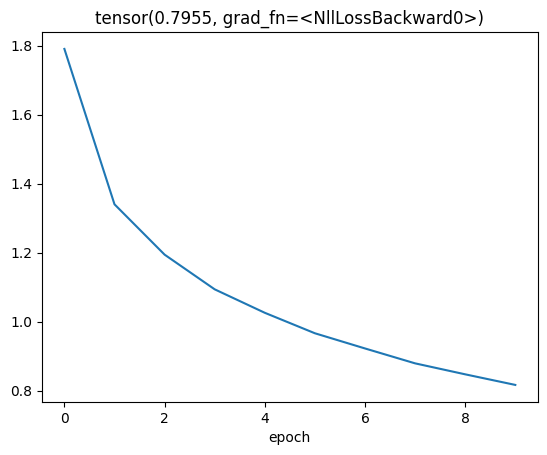

In [11]:
plt.plot(loss_)

plt.title(loss)

plt.xlabel('epoch')

plt.show()

In [12]:
PATH = './cifar_net.pth' # 모델 저장 경로
torch.save(net.state_dict(), PATH) # 모델 저장장

In [13]:
net = Net().to(device) # 모델 선언
net.load_state_dict(torch.load(PATH)) # 모델 parameter 불러오기

<All keys matched successfully>

In [16]:
correct = 0
total = 0
with torch.no_grad(): # 파라미터 업데이트 같은거 안하기 때문에 no_grad를 사용.
  # net.eval() # batch normalization이나 dropout을 사용하지 않았기 때문에 사용하지 않음. 항상 주의해야함.
  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1) # 10개의 class중 가장 값이 높은 것을 예측 label로 추출.
    total += labels.size(0) # test 개수
    correct += (predicted == labels).sum().item() # 예측값과 실제값이 맞으면 1 아니면 0으로 합산.

print(f'accuracy of 10000 test images: {100*correct/total}%')
outputs.data # 한 epoch에서 각 batch에서 나온 여기서는 8개의 배치라서 8개의 각 배치에 대한 10개의 class에 대한 score 산출.

accuracy of 10000 test images: 64.3%


tensor([[ 0.0000,  1.0724,  1.3501,  7.0796,  3.0386,  3.9828,  2.6381,  1.1117,
          1.9394,  0.0000],
        [ 1.6064,  0.8529,  3.0882,  8.9621,  3.2757,  7.2768,  0.6471,  6.9804,
          0.0000,  3.0095],
        [ 0.7861,  0.0000,  1.7884,  6.6190,  2.4744,  6.6578,  2.8461,  1.3201,
          2.5151,  0.0000],
        [ 2.0799,  0.0000,  0.4377,  8.1642,  1.0688,  7.3176,  1.2518,  1.5825,
          8.5314,  0.0000],
        [ 0.0000,  0.0000,  6.6914,  9.3328, 10.5725,  7.2905,  8.6606,  4.8397,
          0.0000,  0.0000],
        [ 1.5165,  0.0000,  7.4731,  6.4643,  3.3313, 10.4190,  4.5841,  6.6995,
          0.0000,  0.0000],
        [ 3.8801,  5.4873,  3.8542,  5.4040,  4.6104,  3.3858,  2.2623,  3.4459,
          0.0000,  0.0000],
        [ 2.2572,  0.0000,  5.5780,  2.3804, 12.1657,  3.4754,  3.0993, 17.4987,
          0.0000,  0.7946]])

In [17]:
predicted # 어느 한 배치의 분류 예측값

tensor([3, 3, 5, 8, 4, 5, 1, 7])